In [464]:
import numpy as np
import cv2
import time
import datetime
import os
import shutil
import dill
import pandas as pd
import warnings
import imgaug.augmenters as iaa
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from keras.utils import Sequence, to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.models import Sequential, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.neighbors.kde import KernelDensity
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

In [465]:
class VideoStream:
    
    def __init__(self, filepath):
        self.cap = cv2.VideoCapture(filepath)
        if not self.cap.isOpened():
            raise Exception('Video stream doesn\'t open!')
    
    def __enter__(self):
        return self.cap
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.cap.release()

In [466]:
class ShortVideoWarning(UserWarning):
    
    def __init__(self, message):
        super().__init__()
        self.message = message
        
    def __str__(self):
        return self.message

In [489]:
class Augmentator:
    
    def __init__(
        self,
        rotation_range=(-5, 5),
        width_shift_range=(-0.1, 0.1),
        height_shift_range=(-0.1, 0.1),
        scale_x_range=(0.77, 1.3),
        scale_y_range=(0.77, 1.3),
        horizontal_flip=True,
        preprocessing_function=None,
        seed=None
    ):
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.scale_x_range = scale_x_range
        self.scale_y_range = scale_y_range
        self.horizontal_flip = horizontal_flip
        self.preprocessing_function = preprocessing_function
        self.seed = seed
        
    def augment(self, frame_sequence):
        if self.seed is not None:
            rs = np.random.RandomState(self.seed)
        else:
            rs = np.random
        rotate = rs.randint(self.rotation_range[0], self.rotation_range[1])
        translate_percent = {
            'x': rs.uniform(self.width_shift_range[0], self.width_shift_range[1]),
            'y': rs.uniform(self.height_shift_range[0], self.height_shift_range[1])
        }
        scale = {
            'x': rs.uniform(self.scale_x_range[0], self.scale_x_range[1]),
            'y': rs.uniform(self.scale_x_range[0], self.scale_x_range[1])
        }
        affine = iaa.Affine(
            rotate=rotate,
            translate_percent=translate_percent,
            scale=scale,
        )
        horizontal_flip = iaa.Fliplr(1)
        aug_sort_flg = rs.randint(0, 2)
        if aug_sort_flg:
            aug = [affine, horizontal_flip]
        else:
            aug = [horizontal_flip, affine]
        seq = iaa.Sequential(aug)
        aug_sequence = seq(images=frame_sequence)
        if self.preprocessing_function is not None:
            aug_sequence = np.array(list(map(self.preprocessing_function, aug_sequence)))
        return aug_sequence

In [490]:
class ImageSequenceGenerator(Sequence):
    
    def __init__(
        self,
        videos,
        ids,
        classes,
        class_names,
        augmentator,
        target_size=(224, 224),
        fps=8,
        sequence_time=3,
        shift_time=1,
        batch_size=8,
        shuffle=True,
        seed=None,
        fit_eval=True
    ):
        self.videos = videos
        self.ids = ids
        self.classes = classes
        self.class_names = class_names
        self.augmentator = augmentator
        self.target_size = target_size
        self.fps = fps
        self.sequence_time = sequence_time
        self.shift_time = shift_time
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.fit_eval = fit_eval
        
        self.timesteps = self.fps * self.sequence_time
        self.shift_frames = self.fps * self.shift_time
        
        self.skip_id = []
        self.start_positions = []
        self.indexes = None
        
        self.__check_videos_total_time()
        self.__make_start_positions()
        self.on_epoch_end()

    def __check_videos_total_time(self):
        all_ids = os.listdir(self.videos)
        self.skip_id = []
        for id_ in all_ids:
            video_path = os.path.join(self.videos, id_)
            with VideoStream(video_path) as cap:
                frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = cap.get(cv2.CAP_PROP_FPS)
                total_time = frames_cnt / fps
                if total_time < self.sequence_time:
                    self.skip_id.append(id_)
                    warn_message = 'Video {} has time {} less than sequence_time {} and will be skipped'.format(
                        id_,
                        total_time,
                        self.sequence_time
                    )
                    warnings.warn(ShortVideoWarning(warn_message))
    
    def __next_frame_step(self, fps):
        if self.fps is None:
            next_frame_step = 1
        else:
            next_frame_step = int(np.ceil(fps / self.fps))
        return next_frame_step
    
    def __make_start_positions(self):
        for id_ in self.ids:
            if id_ not in self.skip_id:
                video_path = os.path.join(self.videos, id_)
                with VideoStream(video_path) as cap:
                    frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    fps = cap.get(cv2.CAP_PROP_FPS)
                    next_frame_step = self.__next_frame_step(fps)
                    start_positions = range(
                        0,
                        frames_cnt - self.timesteps * next_frame_step,
                        self.shift_frames * next_frame_step
                    )
                    for start_position in start_positions:
                        self.start_positions.append((id_, start_position))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.start_positions))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        length = int(np.ceil(len(len(self.start_positions)) / float(self.batch_size)))
        return length
    
    def __get_x(self, batch_start_positions):
        batch_x = []
        for id_, start_position in batch_start_positions:
            video_path = os.path.join(self.videos, id_)
            with VideoStream(video_path) as cap:
                fps = cap.get(cv2.CAP_PROP_FPS)
                next_frame_step = self.__next_frame_step(fps)
                frame_sequence = []
                current_pos = start_position
                for i in range(self.timesteps):
                    cap.set(cv2.CAP_PROP_POS_FRAMES, current_pos)
                    ret, frame = cap.read()
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, self.target_size)
                    frame_sequence.append(frame)
                    current_pos += next_frame_step
                frame_sequence = np.array(frame_sequence)
                frame_sequence = self.augmentator.augment(frame_sequence)
            batch_x.append(frame_sequence)
        batch_x = np.array(batch_x)
        return batch_x
    
    def __get_y(self, batch_start_positions):
        batch_y = []
        for id_, start_position in batch_start_positions:
            index = self.ids.index(id_)
            batch_y.append(self.classes[index])
        batch_y = np.array(batch_y)
        batch_y = to_categorical(batch_y, num_classes=len(self.class_names))
        return batch_y
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_start_positions = [self.start_positions[i] for i in indexes]
        batch_x = self.__get_x(batch_start_positions)
        if self.fit_eval:
            batch_y = self.__get_y(batch_start_positions)
            return batch_x, batch_y
        return batch_x
    
    def test(self, idx):
        return self.__getitem__(idx)

In [491]:
def scale_image(img):
    scaled_img = img / 255
    return scaled_img

In [492]:
def read_ids(filename):
    ids = []
    classes = []
    with open(filename) as f:
        next(f)
        for line in f:
            line = line.strip()
            id_, class_ = line.split(',')
            ids.append(id_)
            classes.append(class_)
    return ids, classes

In [493]:
train_ids, train_classes = read_ids('../IDs/train.csv')
valid_ids, valid_classes = read_ids('../IDs/valid.csv')
test_ids, test_classes = read_ids('../IDs/test.csv')

In [494]:
augmentator = Augmentator(preprocessing_function=scale_image)

In [495]:
train_generator = ImageSequenceGenerator('../videos', train_ids, train_classes, ['0', '1'], augmentator)

In [496]:
sequence = train_generator.test(10)

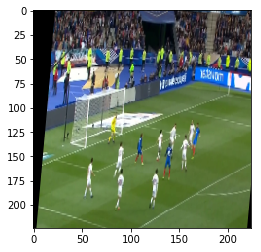

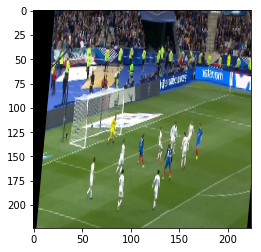

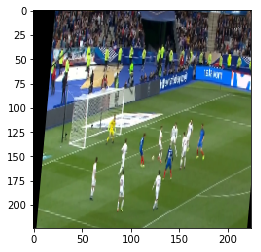

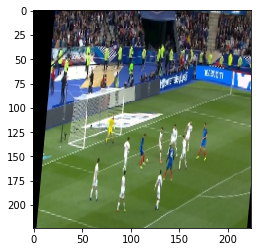

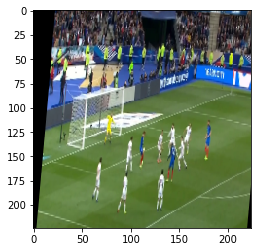

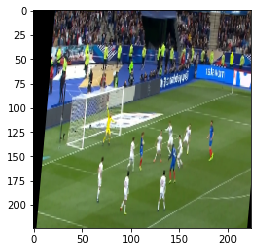

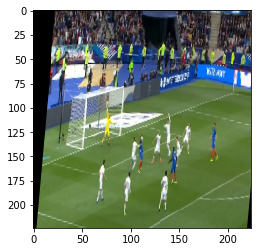

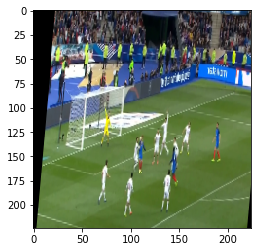

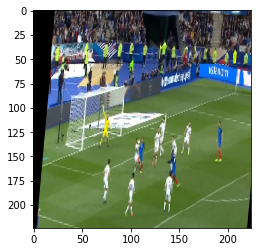

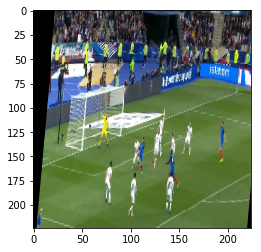

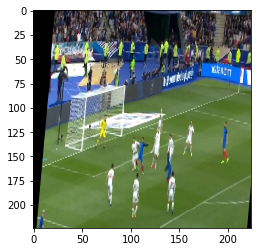

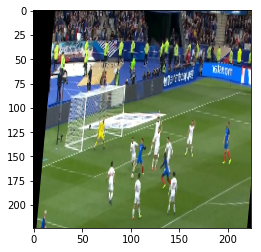

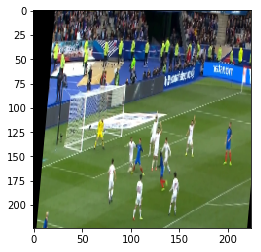

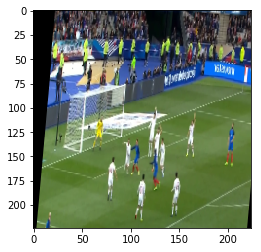

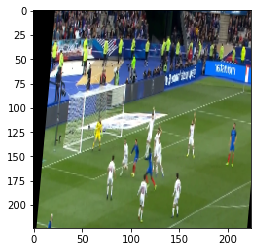

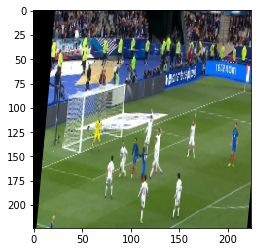

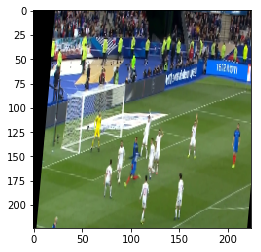

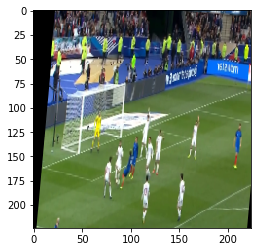

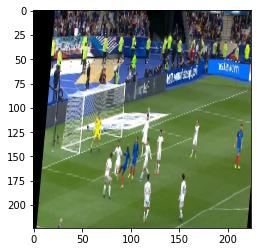

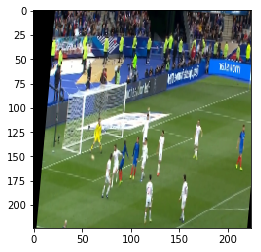

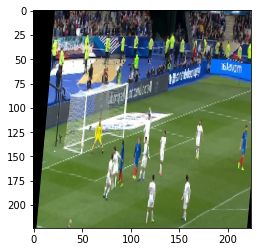

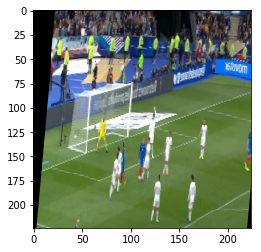

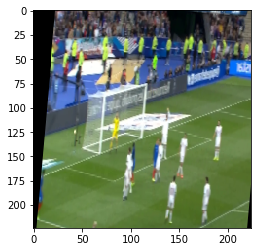

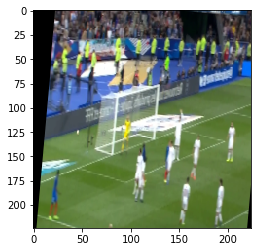

In [497]:
for s in sequence[0][0]:
    plt.imshow(s)
    plt.show()